# $\ell 1$ Wavelet Regularized Reconstruction

This notebook reproduce experiments with $\ell 1$ wavelet regularized reconstruction described in [Accelerating Non-Cartesian MRI Reconstruction Convergence using k-space Preconditioning](https://arxiv.org/abs/1902.09657).

In [1]:
%matplotlib notebook

import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
import numpy as np
try:
    import mkl
    mkl.set_num_threads(1)
except:
    pass

## Set parameters and load dataset

In [2]:
max_iter = 30
max_cg_iter = 5
lamda = 0.001

ksp_file = 'data/cardiac/ksp.npy'
coord_file = 'data/cardiac/coord.npy'

# Choose computing device.
# Device(-1) specifies CPU, while others specify GPUs.
# GPU requires installing cupy.
device = sp.Device(0)
xp = device.xp
device.use()

# Load datasets.
ksp = xp.load(ksp_file)
coord = xp.load(coord_file)

## Estimate sensitivity maps using JSENSE

Here we use [JSENSE](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.21245) to estimate sensitivity maps.

In [3]:
mps = mr.app.JsenseRecon(ksp, coord=coord, device=device).run()

## FISTA

<IPython.core.display.Javascript object>


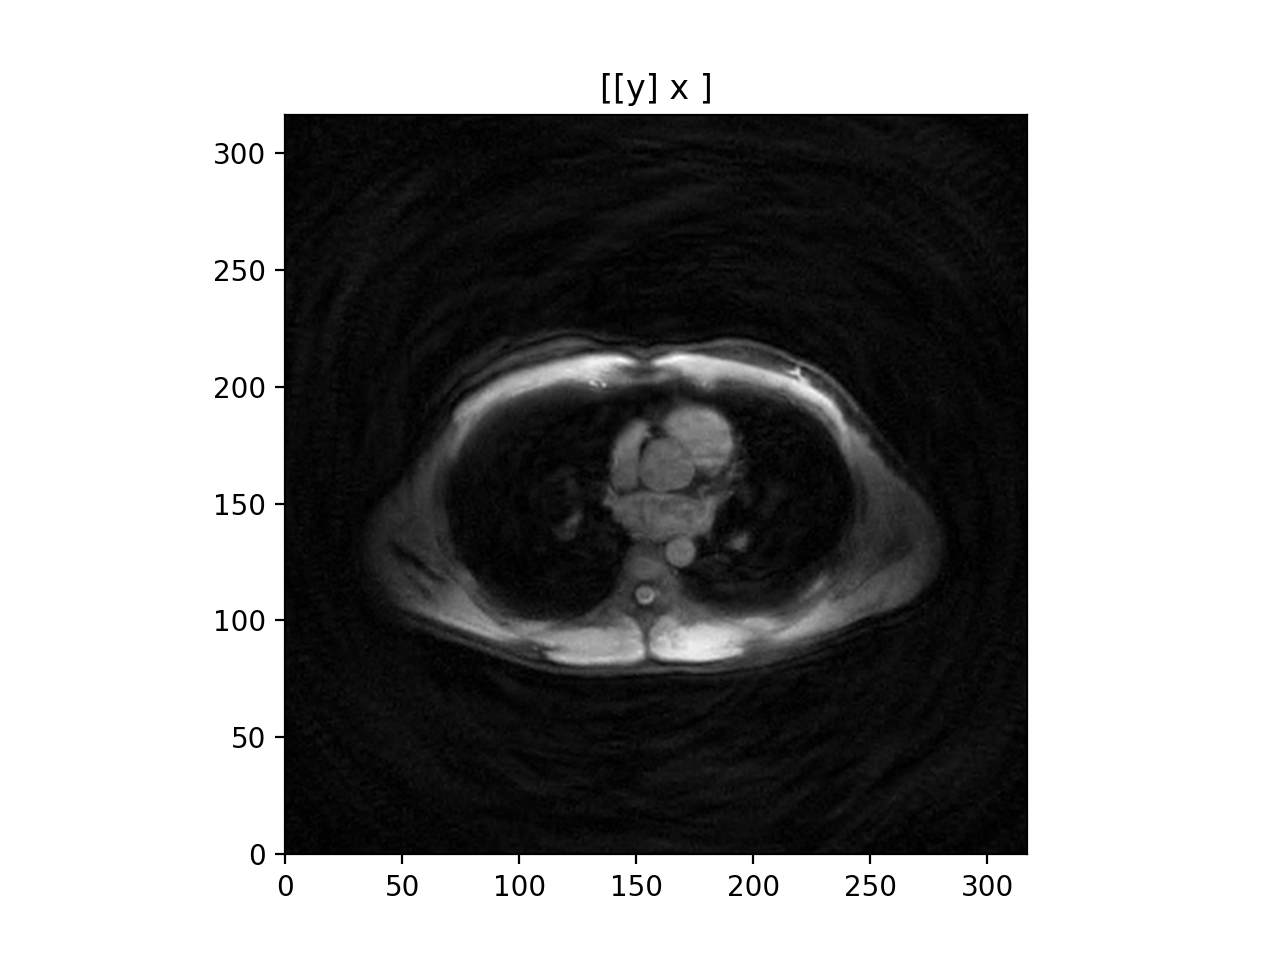

In [4]:
fista_app = mr.app.L1WaveletRecon(
        ksp, mps, lamda=lamda, coord=coord, device=device,
        max_iter=max_iter, save_objective_values=True)

fista_img = fista_app.run()

pl.ImagePlot(fista_img)

## ADMM

<IPython.core.display.Javascript object>


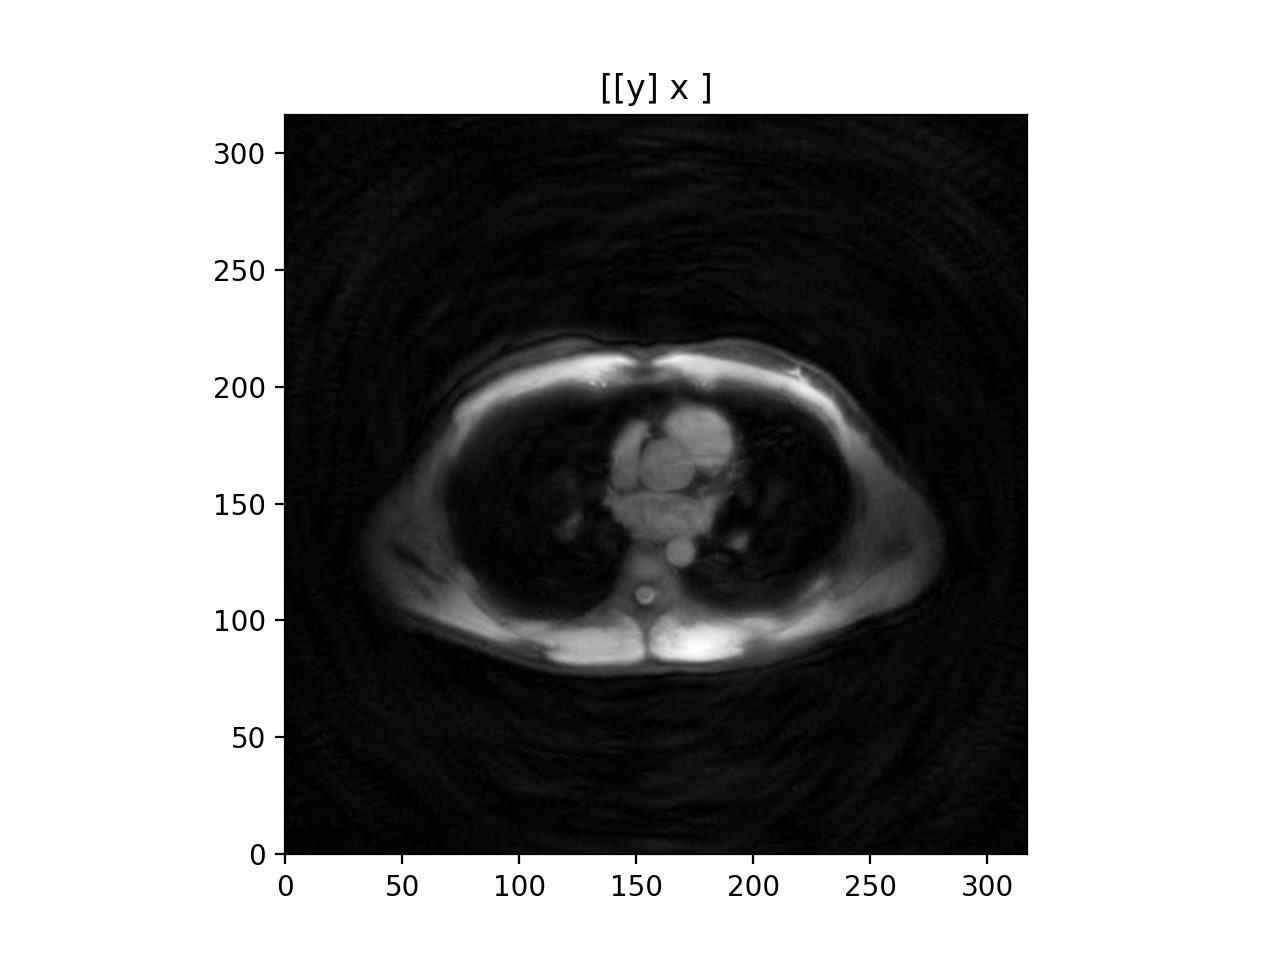

In [5]:
admm_app = mr.app.L1WaveletRecon(
        ksp, mps, solver='ADMM', lamda=lamda, coord=coord, device=device,
        max_iter=max_iter // max_cg_iter, max_cg_iter=max_cg_iter, save_objective_values=True)
admm_img = admm_app.run()

pl.ImagePlot(admm_img)

## ADMM with circulant preconditioner

<IPython.core.display.Javascript object>


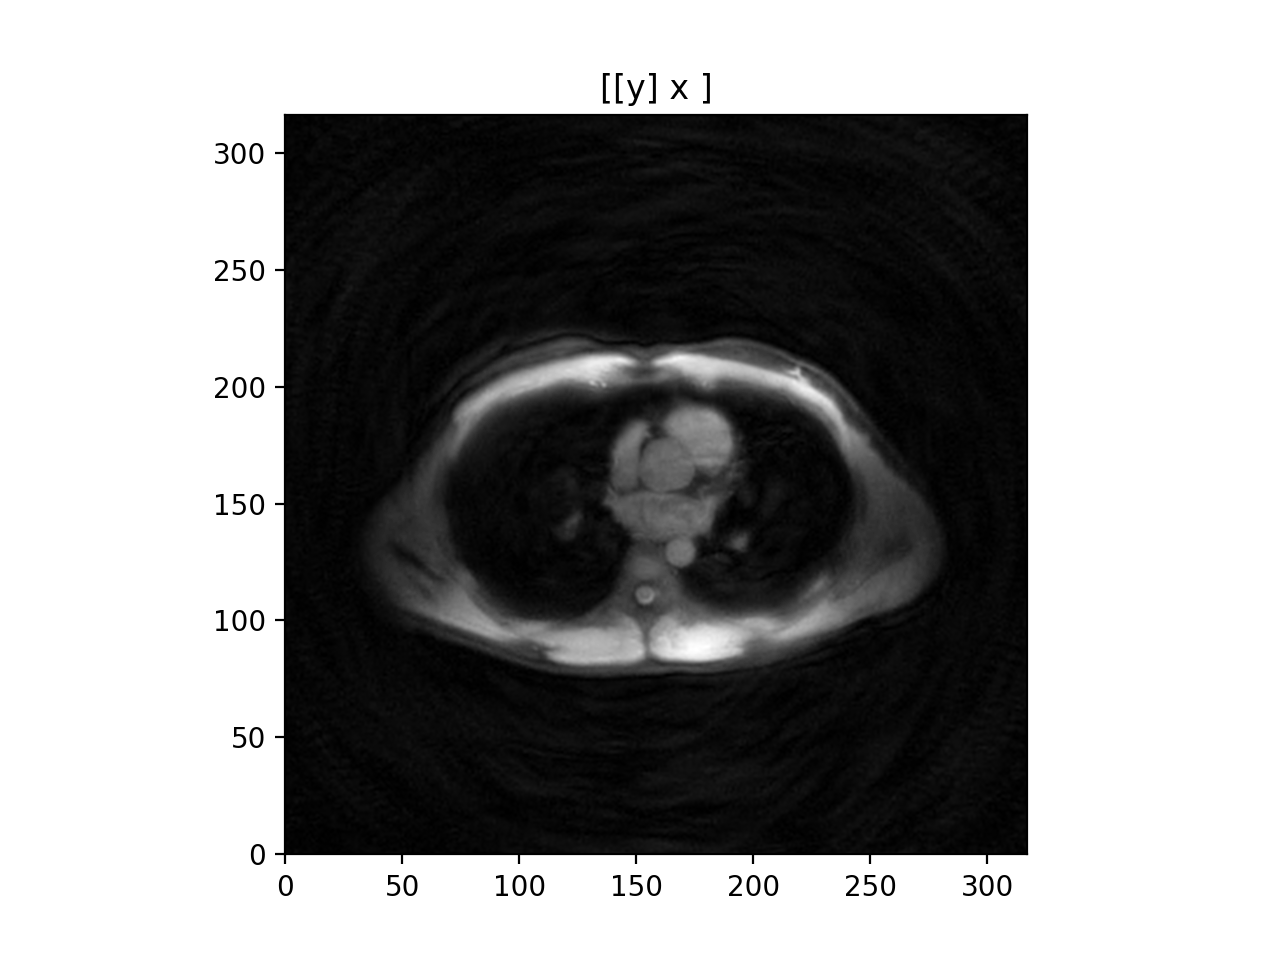

In [6]:
rho = 1
circ_precond = mr.circulant_precond(mps, coord=coord, device=device, lamda=rho)

img_shape = mps.shape[1:]
D = sp.linop.Multiply(img_shape, circ_precond)
P = sp.linop.IFFT(img_shape) * D * sp.linop.FFT(img_shape)

admm_cp_app = mr.app.L1WaveletRecon(
        ksp, mps, solver='ADMM', P=P, lamda=lamda, coord=coord, device=device, rho=rho,
        max_iter=max_iter // max_cg_iter, max_cg_iter=max_cg_iter, save_objective_values=True)
admm_cp_img = admm_cp_app.run()

pl.ImagePlot(admm_cp_img)

## PDHG

<IPython.core.display.Javascript object>


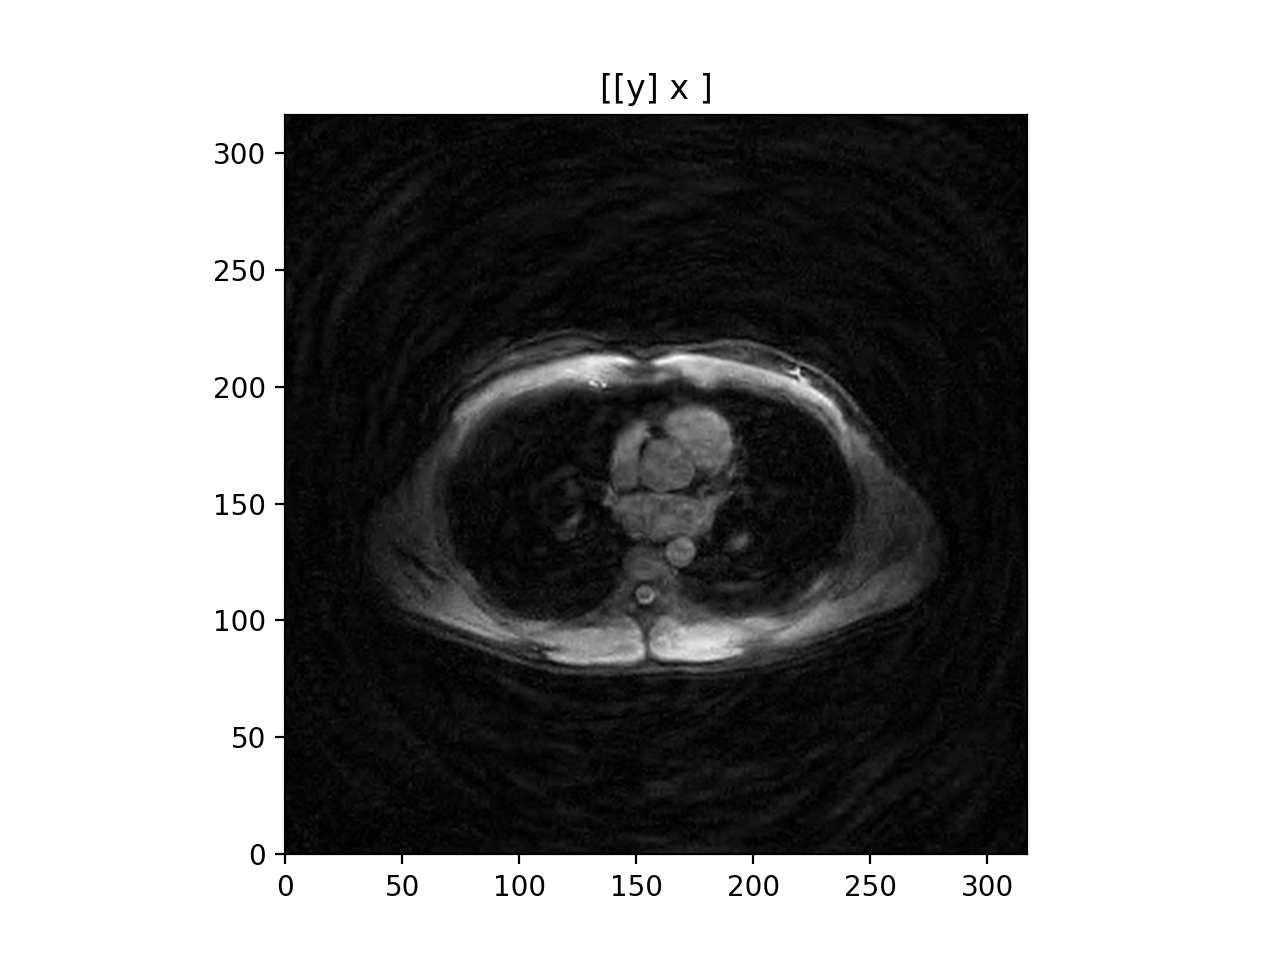

In [7]:
pdhg_app = mr.app.L1WaveletRecon(
        ksp, mps, lamda=lamda, coord=coord, max_iter=max_iter,
        solver='PrimalDualHybridGradient', device=device, save_objective_values=True)
pdhg_img = pdhg_app.run()

pl.ImagePlot(pdhg_img)

## PDHG with density compensation

<IPython.core.display.Javascript object>


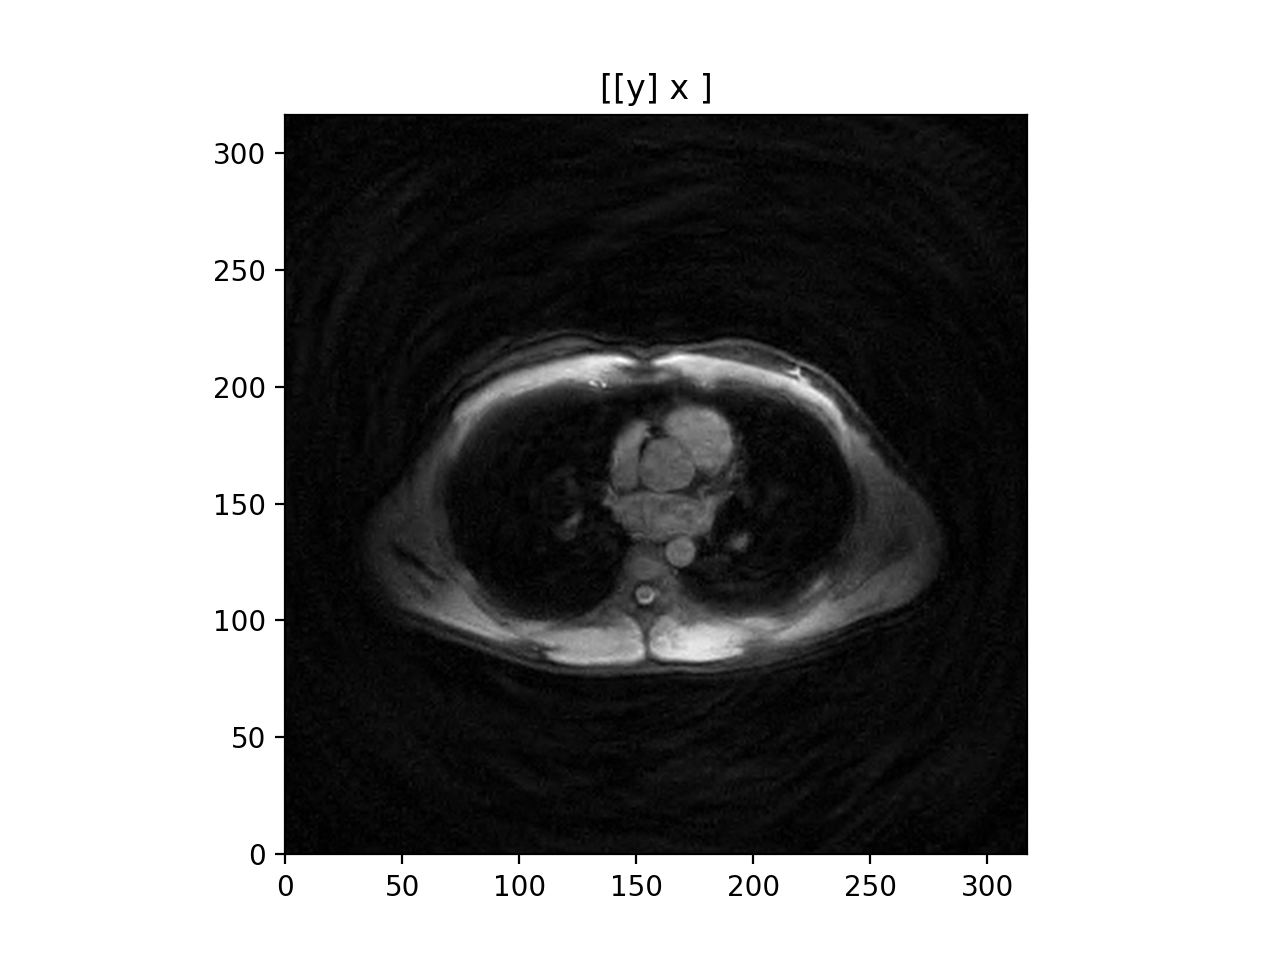

In [8]:
# Compute preconditioner
precond_dcf = mr.pipe_menon_dcf(coord, device=device)

pdhg_dcf_app = mr.app.L1WaveletRecon(
        ksp, mps, lamda=lamda, coord=coord, sigma=precond_dcf, max_iter=max_iter,
        solver='PrimalDualHybridGradient', device=device, save_objective_values=True)
pdhg_dcf_img = pdhg_dcf_app.run()

pl.ImagePlot(pdhg_dcf_img)

## PDHG with single-channel preconditioner

<IPython.core.display.Javascript object>


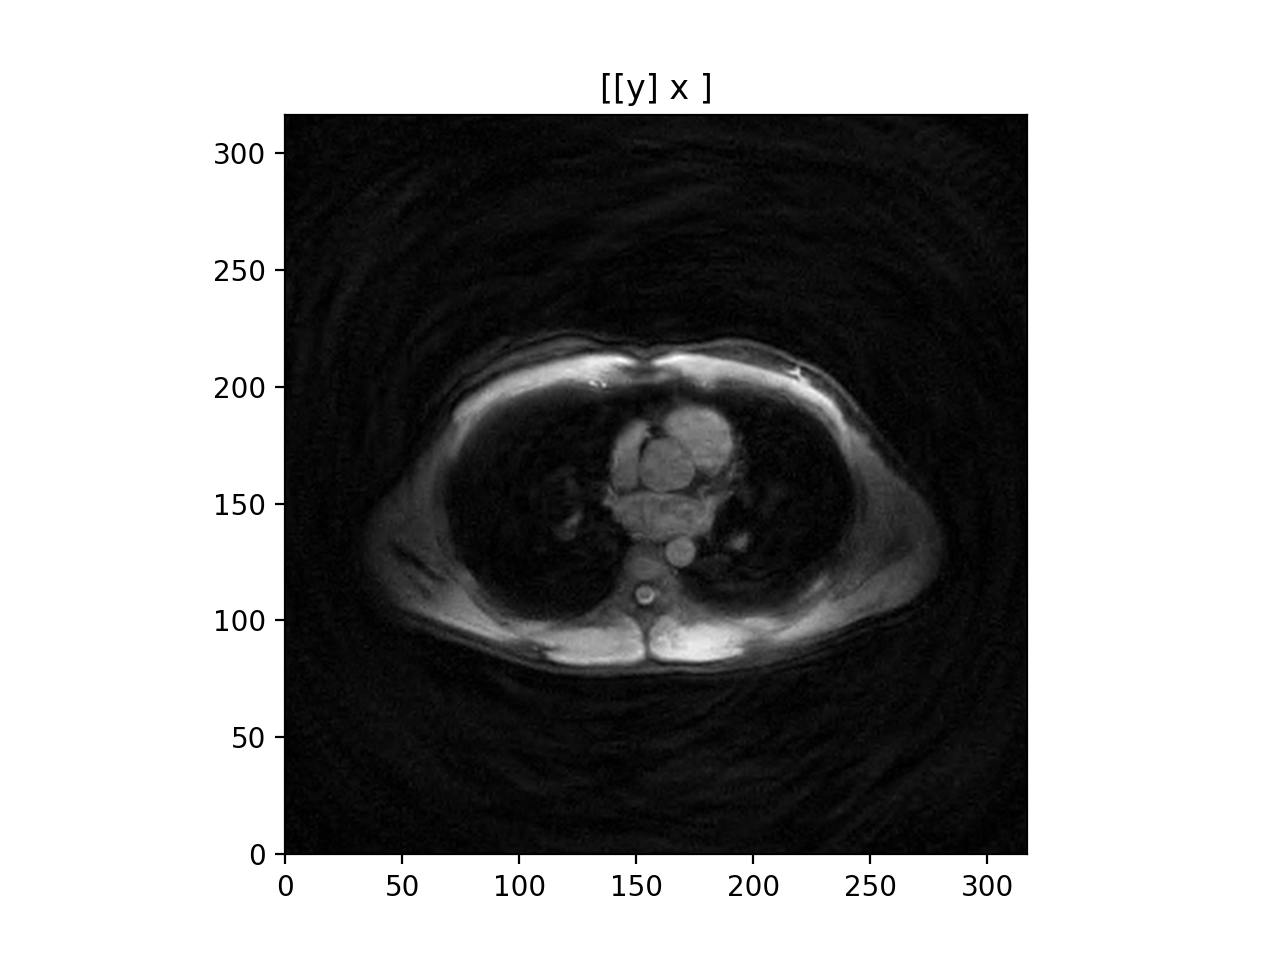

In [9]:
# Compute preconditioner
ones = np.ones_like(mps)
ones /= len(mps)**0.5
precond_sc = mr.kspace_precond(ones, coord=coord, device=device)

pdhg_sc_app = mr.app.L1WaveletRecon(
        ksp, mps, lamda=lamda, coord=coord, sigma=precond_sc, max_iter=max_iter,
        solver='PrimalDualHybridGradient', device=device, save_objective_values=True)
pdhg_sc_img = pdhg_sc_app.run()

pl.ImagePlot(pdhg_sc_img)

## PDHG with multi-channel preconditioner

<IPython.core.display.Javascript object>


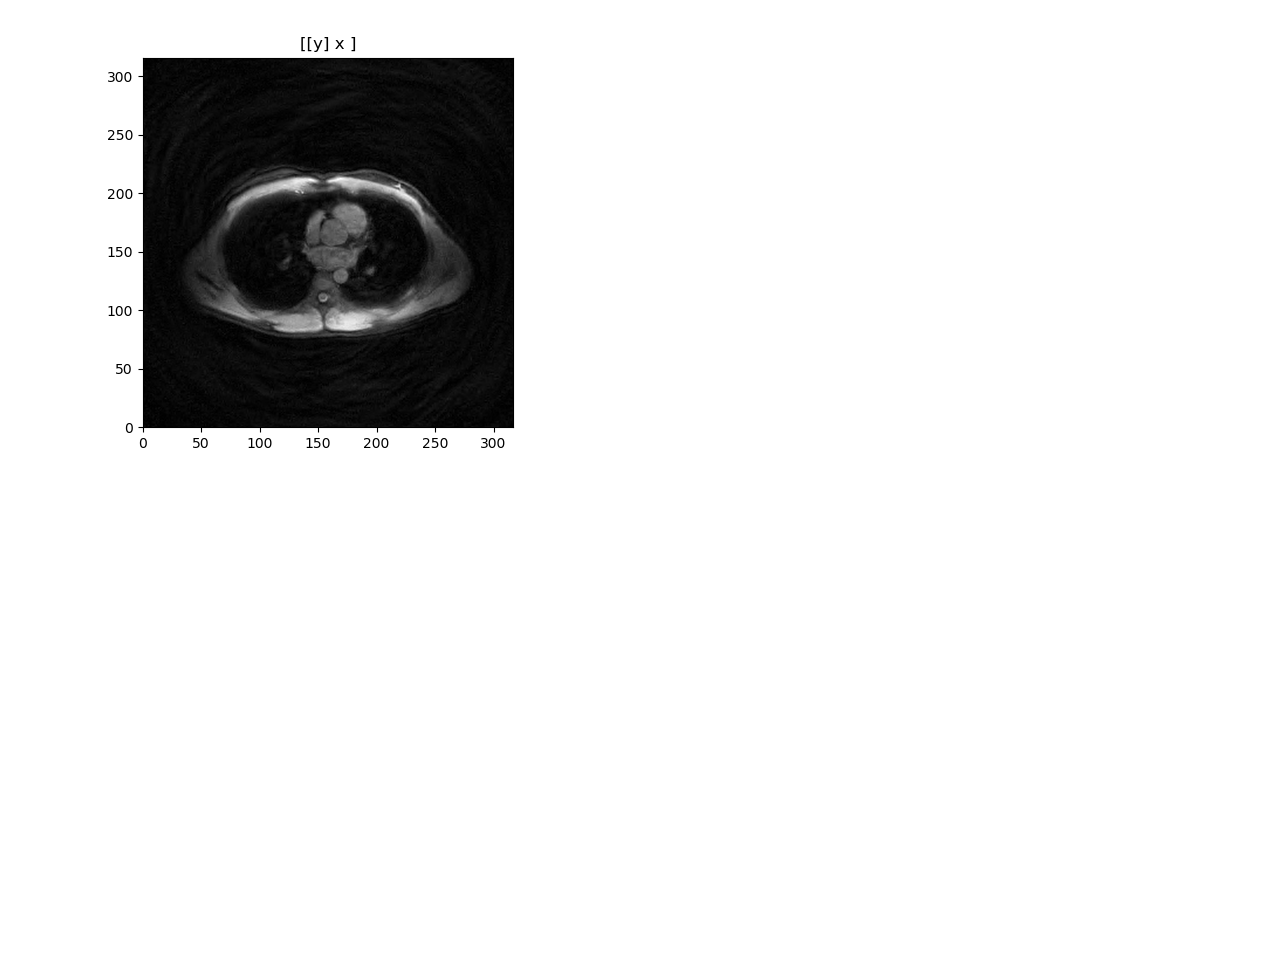

In [10]:
# Compute preconditioner
precond_mc = mr.kspace_precond(mps, coord=coord, device=device)

pdhg_mc_app = mr.app.L1WaveletRecon(
        ksp, mps, lamda=lamda, coord=coord, sigma=precond_mc, max_iter=max_iter,
        solver='PrimalDualHybridGradient', device=device, save_objective_values=True)
pdhg_mc_img = pdhg_mc_app.run()

pl.ImagePlot(pdhg_mc_img)

## Convergence curves

<IPython.core.display.Javascript object>


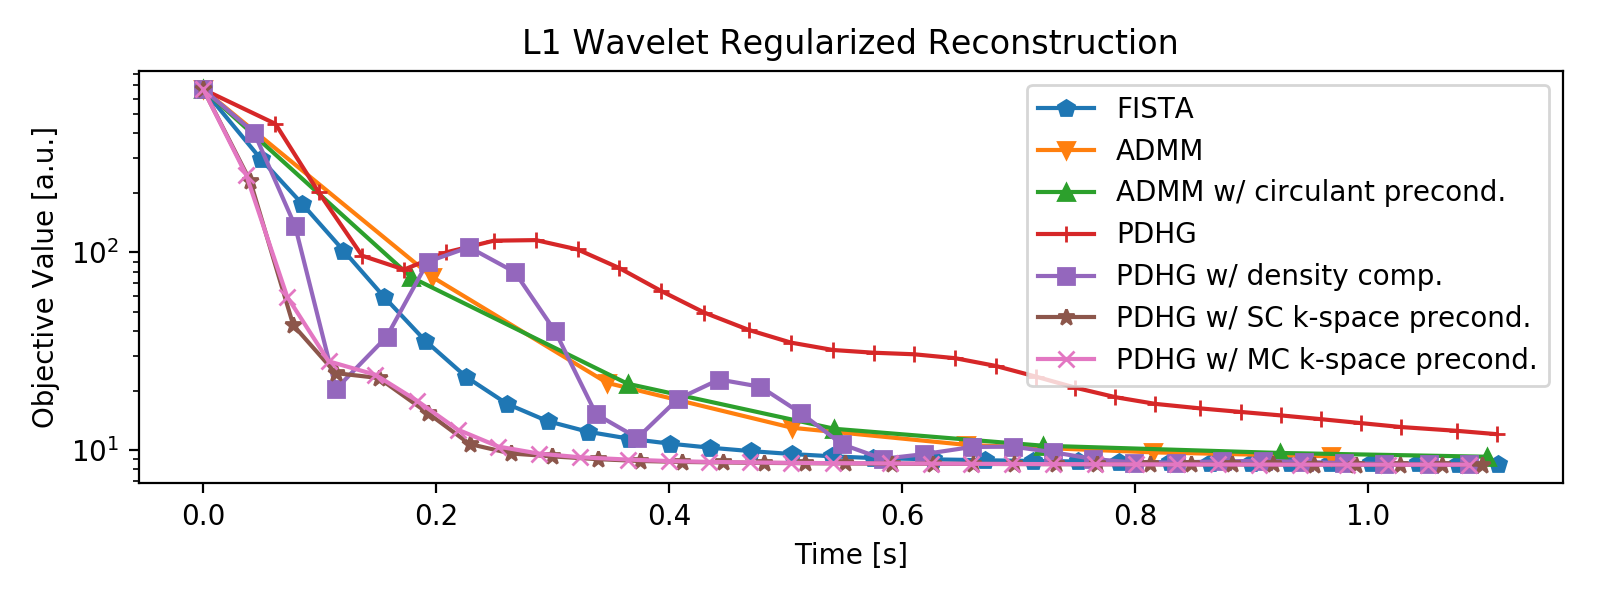

In [11]:
plt.figure(figsize=(8, 3))
plt.semilogy(fista_app.time, fista_app.objective_values,
            marker='p', color='C0')
plt.semilogy(admm_app.time, admm_app.objective_values,
               marker='v', color='C1')
plt.semilogy(admm_cp_app.time, admm_cp_app.objective_values,
               marker='^', color='C2')
plt.semilogy(pdhg_app.time, pdhg_app.objective_values,
               marker='+', color='C3')
plt.semilogy(pdhg_dcf_app.time, pdhg_dcf_app.objective_values,
               marker='s', color='C4')
plt.semilogy(pdhg_sc_app.time, pdhg_sc_app.objective_values,
               marker='*', color='C5')
plt.semilogy(pdhg_mc_app.time, pdhg_mc_app.objective_values,
               marker='x', color='C6')
plt.legend(['FISTA',
            'ADMM',
            'ADMM w/ circulant precond.',
            'PDHG',
            'PDHG w/ density comp.',
            'PDHG w/ SC k-space precond.',
            'PDHG w/ MC k-space precond.'])
plt.ylabel('Objective Value [a.u.]')
plt.xlabel('Time [s]')
plt.title(r"L1 Wavelet Regularized Reconstruction")
plt.tight_layout()
plt.show()